https://mp.weixin.qq.com/s/8N2SfQ5lBtS4T1b9uDOG9A

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from PIL import Image

In [2]:
# 定义超参数
Epochs = 100
Lr_Rate = 1e-3
Batch_Size = 128

In [3]:
# 图像转换
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [4]:
train_set = datasets.MNIST(root='../../dataset/data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='../../dataset/data', train=False, download=True, transform=transform)

0it [00:00, ?it/s]

 99%|██████████████████████████████████████████████████████████████████▎| 9805824/9912422 [00:11<00:00, 1037746.64it/s]

Extracting ../../dataset/data\MNIST\raw\train-images-idx3-ubyte.gz to ../../dataset/data\MNIST\raw



0it [00:00, ?it/s]


  0%|                                                                                        | 0/28881 [00:00<?, ?it/s]
32768it [00:00, 40762.82it/s]                                                                                          

0it [00:00, ?it/s]

Extracting ../../dataset/data\MNIST\raw\train-labels-idx1-ubyte.gz to ../../dataset/data\MNIST\raw



 81%|███████████████████████████████████████████████████████▍            | 1343488/1648877 [00:02<00:00, 620236.70it/s]
1654784it [00:03, 545580.02it/s]                                                                                       

0it [00:00, ?it/s]

Extracting ../../dataset/data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../../dataset/data\MNIST\raw



8192it [00:00, 12976.36it/s]                                                                                           


Extracting ../../dataset/data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../../dataset/data\MNIST\raw
Processing...
Done!


In [7]:
train_loader = DataLoader(train_set, batch_size=Batch_Size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=Batch_Size, shuffle=True)

In [8]:
print(train_set)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../../dataset/data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [9]:
print(train_set.classes)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [10]:
# 定义模型的AutoEncoder类
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        # 编码器
        self.enc1 = nn.Linear(in_features=784,out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)
        # 解码器
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)
    def forward(self,x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))

        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))
        
        return x

In [11]:
model = AutoEncoder()
print(model)

AutoEncoder(
  (enc1): Linear(in_features=784, out_features=256, bias=True)
  (enc2): Linear(in_features=256, out_features=128, bias=True)
  (enc3): Linear(in_features=128, out_features=64, bias=True)
  (enc4): Linear(in_features=64, out_features=32, bias=True)
  (enc5): Linear(in_features=32, out_features=16, bias=True)
  (dec1): Linear(in_features=16, out_features=32, bias=True)
  (dec2): Linear(in_features=32, out_features=64, bias=True)
  (dec3): Linear(in_features=64, out_features=128, bias=True)
  (dec4): Linear(in_features=128, out_features=256, bias=True)
  (dec5): Linear(in_features=256, out_features=784, bias=True)
)


In [13]:
# 定义损失函数和优化方法
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=Lr_Rate)

In [14]:
# 启动CUDA环境
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

In [15]:
# 创建一个目录来保存结果
def make_dir():
    image_dir = '../../dataset\mnist_out_images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)

In [16]:
# 保存模型生成的重建图像
def save_decod_img(img,epoch):
    img = img.view(img.size(0),1,28,28)
    save_image(img,'../../dataset/mnist_out_images/Autoencoder_image{}.png'.format(epoch))

In [17]:
# 训练模型
def training(model,train_loader,Epochs):
    train_loss = []
    for epoch in range(Epochs):
        running_loss = 0.0
        for data in train_loader:
            img,_ = data
            img = img.to(device)
            img = img.view(img.size(0),-1)
            optimizer.zero_grad()
            outputs = model(img)
            loss = criterion(outputs,img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss = running_loss / len(train_loader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(epoch+1, Epochs, loss))
        if epoch % 5 == 0:
            save_decod_img(outputs.cpu().data,epoch)
    return train_loss

In [19]:
for data in train_loader:
    print(type(data))

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'li

In [26]:
def test_image_reconstruct(model,test_loader):
    for batch in test_loader:
        img,_ = batch
        img = img.to(device)
        img = img.view(img.size(0),-1)
        outputs = model(img)
        outputs = outputs.view(outputs.size(0),1,28,28).cpu().data
        save_image(outputs,'../../dataset/mnist_out_images/MNIST_reconstruction.png')
        break

In [21]:
device = get_device()
model.to(device)
make_dir()

In [22]:
train_loss = training(model, train_loader, Epochs)

Epoch 1 of 100, Train Loss: 0.924
Epoch 2 of 100, Train Loss: 0.919
Epoch 3 of 100, Train Loss: 0.913
Epoch 4 of 100, Train Loss: 0.909
Epoch 5 of 100, Train Loss: 0.906
Epoch 6 of 100, Train Loss: 0.903
Epoch 7 of 100, Train Loss: 0.901
Epoch 8 of 100, Train Loss: 0.899
Epoch 9 of 100, Train Loss: 0.898
Epoch 10 of 100, Train Loss: 0.897
Epoch 11 of 100, Train Loss: 0.896
Epoch 12 of 100, Train Loss: 0.895
Epoch 13 of 100, Train Loss: 0.894
Epoch 14 of 100, Train Loss: 0.894
Epoch 15 of 100, Train Loss: 0.893
Epoch 16 of 100, Train Loss: 0.893
Epoch 17 of 100, Train Loss: 0.892
Epoch 18 of 100, Train Loss: 0.892
Epoch 19 of 100, Train Loss: 0.892
Epoch 20 of 100, Train Loss: 0.891
Epoch 21 of 100, Train Loss: 0.891
Epoch 22 of 100, Train Loss: 0.891
Epoch 23 of 100, Train Loss: 0.891
Epoch 24 of 100, Train Loss: 0.890
Epoch 25 of 100, Train Loss: 0.890
Epoch 26 of 100, Train Loss: 0.890
Epoch 27 of 100, Train Loss: 0.890
Epoch 28 of 100, Train Loss: 0.890
Epoch 29 of 100, Train Loss: 

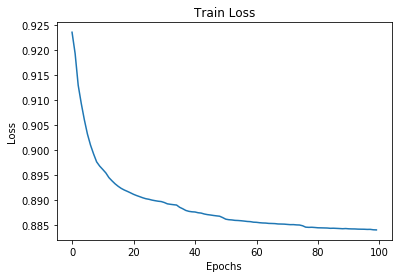

In [23]:
# 可视化损失
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('deep_ae_mnist_loss.png')

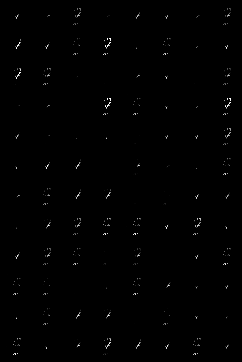

In [25]:
# 可视化训练期间保存的一些图像
Image.open('../../dataset/mnist_out_images/Autoencoder_image0.png')

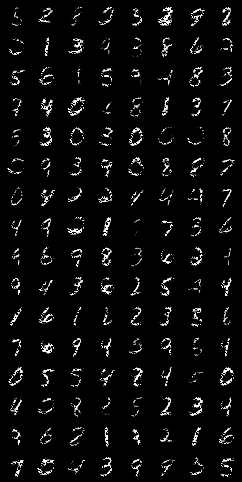

In [28]:
test_image_reconstruct(model, test_loader)
Image.open('../../dataset/mnist_out_images/MNIST_reconstruction.png')